# **Rock Image Classification**

Importing libraries

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Rock Data**

### 1) Create a training and validation dataset

Adding 30 categories and 12 images in each category for the training data

In [ ]:
def training_data(folder_path, save_folder_path):
    image_data = []

    # Iterate through each file in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            # Extract category name from the second word of the filename
            category_name = filename.split('_')[1]

            # Load and process the image
            image_path = os.path.join(folder_path, filename)
            img = load_img(image_path, color_mode='grayscale', target_size=(224, 224))
            img_array = img_to_array(img)
            image_data.append(img_array)

            # Save the image to the respective category folder
            category_folder = os.path.join(save_folder_path, category_name)
            os.makedirs(category_folder, exist_ok=True)
            img.save(os.path.join(category_folder, filename))

    return np.array(image_data)

# Loading train data and saving the images to respective category folders
train_folder_path = '/content/drive/MyDrive/360 Rocks'
train_save_folder_path = 'TrainingData'
train_image_data = training_data(train_folder_path, train_save_folder_path)


In [ ]:
train_image_data = np.repeat(train_image_data, 3, axis=-1)

In [ ]:
train_image_data.shape

(360, 224, 224, 3)

Adding 30 categories and 4 images in each category for the validation data

In [ ]:
def validation_data(folder_path, save_folder_path):
    image_data = []

    # Iterate through each file in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            # Extract category name from the second word of the filename
            category_name = filename.split('_')[1]

            # Load and process the image
            image_path = os.path.join(folder_path, filename)
            img = load_img(image_path, color_mode='grayscale', target_size=(224, 224))
            img_array = img_to_array(img)
            image_data.append(img_array)

            # Save the image to the respective category folder
            category_folder = os.path.join(save_folder_path, category_name)
            os.makedirs(category_folder, exist_ok=True)
            img.save(os.path.join(category_folder, filename))

    return np.array(image_data)

# Loading train data and saving the images to respective category folders
val_folder_path = '/content/drive/MyDrive/120 Rocks'
val_save_folder_path = 'ValidationData'
val_image_data = validation_data(val_folder_path, val_save_folder_path)

In [ ]:
val_image_data = np.repeat(val_image_data, 3, axis=-1)

In [ ]:
val_image_data.shape

(120, 224, 224, 3)

## 2) Build the input pipeline.

In [ ]:
train_path = 'TrainingData'
val_path = 'ValidationData'

# Assuming you want each batch to contain 32 images
batch_size = 32
num_train_images = 3600
num_val_images = 3600
image_size = (224, 224)

# Calculate steps per epoch
steps_per_epoch = num_train_images // batch_size
validation_steps = num_val_images // batch_size

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 360 images belonging to 30 classes.
Found 120 images belonging to 30 classes.


## 3) Fine-tune a pretrained neural network

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new model on top
model = Sequential([
    base_model,  # Add the pre-trained base
    GlobalAveragePooling2D(),  # Add GAP to reduce spatial dimensions
    Dropout(0.5),  # Dropout for regularization
    Dense(8, activation='softmax'),  # New dense layer with 8 units
    Dense(30, activation='softmax')  # Final output layer with 30 units for classification
])

# Freeze the base model's layers and compile
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(
    'best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lr_scheduler = LearningRateScheduler(scheduler)


# First phase: Train the added layers
history_phase1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=11,
)

# Second phase: Fine-tune the entire model
for layer in base_model.layers:
    layer.trainable = True  # Unfreeze the entire model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_phase2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,  # Continue fine-tuning for 25 more epochs
)

Epoch 1/11
12/12 [==============================] - 9s 480ms/step - loss: 3.4071 - accuracy: 0.0194 - val_loss: 3.3967 - val_accuracy: 0.0333
Epoch 2/11
12/12 [==============================] - 5s 406ms/step - loss: 3.3886 - accuracy: 0.0389 - val_loss: 3.3869 - val_accuracy: 0.0250
Epoch 3/11
12/12 [==============================] - 6s 544ms/step - loss: 3.3754 - accuracy: 0.0444 - val_loss: 3.3740 - val_accuracy: 0.0417
Epoch 4/11
12/12 [==============================] - 6s 463ms/step - loss: 3.3636 - accuracy: 0.0417 - val_loss: 3.3615 - val_accuracy: 0.0417
Epoch 5/11
12/12 [==============================] - 7s 539ms/step - loss: 3.3469 - accuracy: 0.0694 - val_loss: 3.3513 - val_accuracy: 0.0417
Epoch 6/11
12/12 [==============================] - 5s 411ms/step - loss: 3.3423 - accuracy: 0.0667 - val_loss: 3.3436 - val_accuracy: 0.0500
Epoch 7/11
12/12 [==============================] - 7s 549ms/step - loss: 3.3254 - accuracy: 0.0806 - val_loss: 3.3356 - val_accuracy: 0.0583
Epoch 

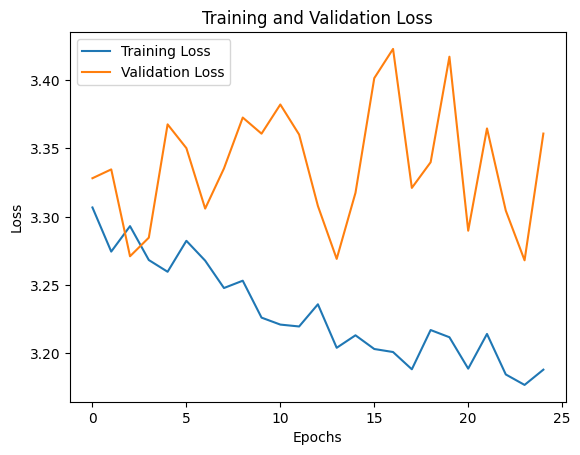

In [ ]:
# Plot training and validation loss
plt.plot(history_phase2.history['loss'], label='Training Loss')
plt.plot(history_phase2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

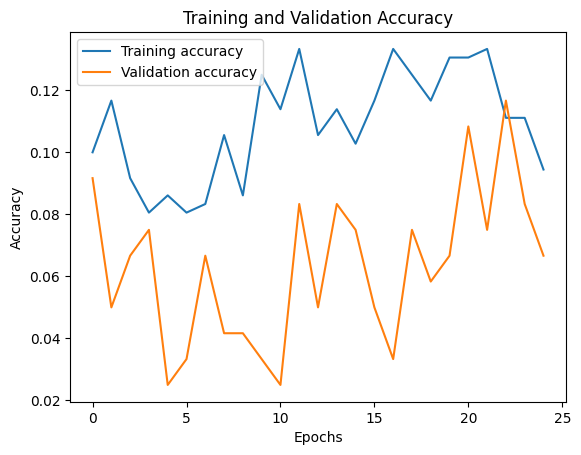

In [ ]:
plt.plot(history_phase2.history['accuracy'], label='Training accuracy')
plt.plot(history_phase2.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

### Network Performance:
- The network's accuracy is quite low, hovering around 2-12% for training and roughly the same for validation, which is far from ideal. Typically, for a classification task, we would expect much higher accuracy, depending on the complexity of the task and the amount of data available.
- The loss is decreasing over time in the training set, which is a good sign. However, the validation loss is not consistently decreasing, indicating that the model might not be learning effectively.

### Convergence:
- There isn't a clear indication of convergence to a stable solution. The validation loss oscillates and, in later epochs, starts increasing, suggesting overfitting, where the model learns the training data too well, including its noise and outliers, and fails to generalize to unseen data.
- The graphs show fluctuations in both accuracy and loss for validation, which suggests that the model is not stabilizing well on the validation set.

### Hyperparameter Tweaks:

- Model Architecture: The sequential model you've set up has a potential bottleneck caused by the dense layer with only 8 units preceding the final 30-unit classification layer. It is typically beneficial to have a gradual reduction in the number of units rather than a sharp decrease. Consider restructuring the dense layers to ensure there's enough capacity to learn the distinctions between the 30 classes.
- Learning Rate and Scheduler: The LearningRateScheduler is defined but not used in the fit calls. Implementing a scheduler that decreases the learning rate as epochs increase might help the model converge more smoothly. Make sure to include the lr_scheduler in the callbacks for both training phases.
- Callbacks: The ModelCheckpoint and EarlyStopping are declared but not used in the training calls. Make sure these are included in the callbacks list during model fitting to save the best model and to stop training if the validation loss is not improving.
- Optimizer: You are using the Adam optimizer with its default settings. It could be beneficial to experiment with different learning rates or even different optimizers to see if they result in better convergence.
- Regularization: The dropout rate of 0.5 is quite high, which is usually good for regularization, but if the network is not large enough or the dropout is too aggressive, it might prevent the network from learning effectively. Experimenting with different rates might yield improvements.

It's important to iterate over these hyperparameters systematically, possibly using grid search or random search, to find the best combination. Additionally, if the dataset is small or not diverse enough, gathering more data would be crucial.

Considering these tweaks and keeping an eye on both accuracy and loss graphs would likely help improve the performance of the network. The ultimate goal is to have a model that generalizes well to new data, and that often requires a combination of the right architecture, regularization techniques, and training procedure.

## 4) Compute the correlation coefficients

In [ ]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from scipy.spatial import procrustes
from tensorflow.keras.applications.xception import preprocess_input, Xception  # Assuming Xception model

# Define paths to your datasets
train_dataset_path = '/content/TrainingData'
val_dataset_path = '/content/ValidationData'

# Extract the model till the pen-ultimate layer
model2 = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Load and process images function
def load_and_process_images(dataset_path):
    image_list = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith((".png", ".jpg", ".jpeg")):  # Check file extensions
                img_path = os.path.join(root, file)
                img = image.load_img(img_path, target_size=(224, 224))
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array = preprocess_input(img_array)
                image_list.append(img_array)
    if not image_list:
        raise ValueError(f"No images found in the dataset path {dataset_path}.")
    return np.vstack(image_list)



# Load human rankings
human_data_train = pd.read_csv('/content/mds_360.txt', header=None, delimiter='\s+').values
human_data_val = pd.read_csv('/content/mds_120.txt', header=None, delimiter='\s+').values

# Load and preprocess the images
train_images = load_and_process_images(train_dataset_path)
val_images = load_and_process_images(val_dataset_path)

# Extract model features
def extract_features(model, images):
    return model2.predict(images)

train_features = extract_features(model, train_images)
val_features = extract_features(model, val_images)

# Print the shapes of training and validation features
print("Shape of train_features:", train_features.shape)
print("Shape of val_features:", val_features.shape)


4/4 [==============================] - 0s 113ms/step
Shape of train_features: (360, 8)
Shape of val_features: (120, 8)


## Calculate Correlation coefficient

In [ ]:
def compute_procrustes(human_data, features):
    if human_data.shape != features.shape:
        raise ValueError("Dimension mismatch: Human data dimensions {} vs. Features dimensions {}".format(human_data.shape, features.shape))

    disparities = []
    correlations = []

    for i in range(features.shape[1]):  # Iterate through each dimension
        mtx1, mtx2, disparity = procrustes(human_data[:, [i]], features[:, [i]])
        correlation = np.corrcoef(human_data[:, i], features[:, i])[0, 1]
        disparities.append(disparity)
        correlations.append(correlation)

    average_disparity = np.mean(disparities)
    average_correlation = np.mean(correlations)

    return correlations, disparities, average_correlation, average_disparity

def report_correlations_and_disparity(correlations, disparities, average_correlation, average_disparity, dataset_name):
    print(f"Results for {dataset_name}:")
    print("Correlations for each dimension:")
    for idx, corr in enumerate(correlations, 1):
        print(f"Dimension {idx}: {corr:.4f}")
    print(f"Average Correlation: {average_correlation:.4f}")
    print(f"Average Disparity: {average_disparity:.4f}\n")

# Example usage
train_correlations, train_disparities, train_avg_corr, train_avg_disp = compute_procrustes(human_data_train, train_features)
val_correlations, val_disparities, val_avg_corr, val_avg_disp = compute_procrustes(human_data_val, val_features)


# **Report the correlation coefficients**

In [ ]:
report_correlations_and_disparity(train_correlations, train_disparities, train_avg_corr, train_avg_disp, "Training Data")
report_correlations_and_disparity(val_correlations, val_disparities, val_avg_corr, val_avg_disp, "Validation Data")

Results for Training Data:
Correlations for each dimension:
Dimension 1: 0.1820
Dimension 2: 0.1217
Dimension 3: -0.0392
Dimension 4: -0.0616
Dimension 5: 0.0577
Dimension 6: -0.0278
Dimension 7: -0.0717
Dimension 8: 0.0221
Average Correlation: 0.0229
Average Disparity: 0.9921

Results for Validation Data:
Correlations for each dimension:
Dimension 1: 0.1885
Dimension 2: 0.1566
Dimension 3: 0.1046
Dimension 4: -0.0223
Dimension 5: 0.0603
Dimension 6: 0.0727
Dimension 7: 0.0312
Dimension 8: -0.0688
Average Correlation: 0.0653
Average Disparity: 0.9892

